# section 1

In [254]:
import sys
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install matplotlib.pyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.integrate import quad
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [255]:
# df22 = pd.read_csv(r'C:\Users\rafae\OneDrive\Documentos\prog\coding\modelagem-estatistica\MICRODADOS_ENEM_2022.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
#                                                                                                                           "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
#                                                                                                                           "NO_MUNICIPIO_PROVA","SG_UF_PROVA",
#                                                                                                                           "NU_NOTA_COMP3", "NU_NOTA_REDACAO",
#                                                                                                                           "Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025"]).dropna()

In [256]:
# computador fgv
df22 = pd.read_csv(r'C:\Users\b47244\Documents\Modelagem-Estatistica\dados\MICRODADOS_ENEM_2022.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
                                                                                                                          "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
                                                                                                                          "NO_MUNICIPIO_PROVA","SG_UF_PROVA",
                                                                                                                          "NU_NOTA_COMP3", "NU_NOTA_REDACAO",
                                                                                                                          "Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025"]).dropna()

Agora, iremos tratar esses dados:

In [257]:
# apenas quem nao zerou a competencia 3
df22 = df22[df22['NU_NOTA_COMP3']!=0]

# apenas quem nao zerou a competencia 3
df22 = df22[df22['NU_NOTA_REDACAO']!=0]

In [258]:
# Masculino = 1 e Feminino = 0
df22['TP_SEXO'] = df22['TP_SEXO'].replace('M',1).replace('F',0)

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\1660209483.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df22['TP_SEXO'] = df22['TP_SEXO'].replace('M',1).replace('F',0)


In [259]:
# apenas quem declarou a etnia e criar dummies
df22 = df22[df22['TP_COR_RACA']!=0]

print(len(df22))
print(df22['TP_COR_RACA'].value_counts())

df22 = pd.get_dummies(df22, columns=['TP_COR_RACA'], prefix='TP_COR_RACA')

2322706
TP_COR_RACA
1    1044990
3     964942
2     257575
4      44067
5      11132
Name: count, dtype: int64


In [260]:
# Ao invés de usar o nome dos municipios, iremos verificar se o aluno fez a prova em uma capital
capitais = [
    'Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 
    'Brasília+Vitória+Goiânia+São Luís', 'Cuiabá', 'Campo Grande', 
    'Belo Horizonte', 'Belém', 'João Pessoa', 'Curitiba', 'Recife', 
    'Teresina', 'Rio de Janeiro', 'Natal', 'Porto Alegre', 'Porto Velho', 
    'Boa Vista', 'Florianópolis', 'São Paulo', 'Aracaju', 'Palmas'
]

df22['CAPITAL'] = df22['NO_MUNICIPIO_PROVA'].apply(lambda x: 1 if x in capitais else 0)
df22 = df22.drop('NO_MUNICIPIO_PROVA',axis=1)

In [261]:
# proporção de fora da capital é maior em índios
for i in range(1,6):   
    print(f"raça cor {i}: ", df22[df22[f"TP_COR_RACA_{i}"]== True]['CAPITAL'].sum()/len(df22[df22[f"TP_COR_RACA_{i}"]== True]))

raça cor 1:  0.256550780390243
raça cor 2:  0.2879821411239445
raça cor 3:  0.2431389658653059
raça cor 4:  0.2732430163160642
raça cor 5:  0.2020301832554797


In [262]:
# entendendo onde os indios estao
# esse conjunto de dados NAO é um pedaço que representa a população geral
# de indios. Note que PE é apenas o 4 estado com maior numero de indios no país.
print(df22[df22['TP_COR_RACA_5']== True]['SG_UF_PROVA'].value_counts())
print(df22['TP_SEXO'].value_counts())

SG_UF_PROVA
PE    1589
AM    1324
BA    1055
SP     878
CE     614
PB     608
MS     602
PA     589
MG     472
RJ     395
GO     330
MA     293
AL     289
RR     244
PI     244
SE     191
RN     164
ES     159
MT     155
PR     151
RO     145
DF     118
SC     115
RS     112
TO     106
AP      95
AC      95
Name: count, dtype: int64
TP_SEXO
0    1429434
1     893272
Name: count, dtype: int64


In [263]:
# iremos usar dummies das regiões do país ao inves do nome dos estados para diminuir o numero de variaveis no modelo

regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

def mapear_regiao(uf):
    for regiao, ufs in regioes.items():
        if uf in ufs:
            return regiao
    return None
df22['Regiao'] = df22['SG_UF_PROVA'].apply(mapear_regiao)

df22 = df22.drop('SG_UF_PROVA',axis=1)
df22 = pd.get_dummies(df22, columns=['Regiao'], prefix='Regiao')

In [264]:
# a distribuição geografico de indios tambem difere bastante dos não indios
print(df22[df22['TP_COR_RACA_5']== True].loc[:,['Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul']].sum())
print("\n----------------\n")
print(df22[df22['TP_COR_RACA_5']== False].loc[:,['Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul']].sum())

Regiao_Centro-Oeste    1205
Regiao_Nordeste        5047
Regiao_Norte           2598
Regiao_Sudeste         1904
Regiao_Sul              378
dtype: int64

----------------

Regiao_Centro-Oeste    197453
Regiao_Nordeste        809652
Regiao_Norte           241196
Regiao_Sudeste         802191
Regiao_Sul             261082
dtype: int64


In [265]:
# Q005 é sobre quantas pessoas moram na família e Q006 é sobre a renda mensal da familia (soma de cada um dos membros).
# Criaremos uma coluna que contabilize a renda per capita familiar

# Dicionário com as faixas salariais e seus valores numéricos
faixas_salarial = {
    'A': 0,
    'B': 1212,
    'C': 1818,
    'D': 2424,
    'E': 3030,
    'F': 3636,
    'G': 4848,
    'H': 6060,
    'I': 7272,
    'J': 8484,
    'K': 9696,
    'L': 10908,
    'M': 12120,
    'N': 14544,
    'O': 18180,
    'P': 24240,
    'Q': 24241  # Considerando acima de 24240
}

nova_faixa = {
    0: 0,
    1: 303,
    2: 606,
    3: 909,
    4: 1212,
    5: 1818,
    6: 2424,
    7: 3030,
    8: 3636,
    9: 4848,
    10: 6060,
    11: 9090,
    12: 9091, # valores acima de 9091 por pessoa
}

# Função para calcular a renda por pessoa e encontrar a faixa salarial correspondente
def calcular_faixa_renda_por_pessoa(pessoas, renda_familia):
    renda_total = faixas_salarial[renda_familia]
    renda_por_pessoa = renda_total / pessoas
    
    # Encontrar a faixa salarial correspondente
    for faixa, valor in nova_faixa.items():
        if renda_por_pessoa <= valor:
            return faixa
    return 12  # Para renda acima de R$ 9091,00 por pessoa

# Aplicar a função para calcular a faixa salarial da renda por pessoa
df22['faixa_per_capita_fam'] = df22.apply(lambda row: calcular_faixa_renda_por_pessoa(row['Q005'], row['Q006']), axis=1)


In [266]:
# Nota-se que a renda per capita por familia é menor em índios. Proporcionalmente, existem mais individuos com nenhuma renda.
# Isso também motiva a fazer o matching
print(df22['Q005'].value_counts())
print(df22['Q006'].value_counts())
print(df22['faixa_per_capita_fam'].value_counts())
print('-------------')
print(df22[df22['TP_COR_RACA_5']== True]['Q005'].value_counts())
print(df22[df22['TP_COR_RACA_5']== True]['Q006'].value_counts())
print(df22[df22['TP_COR_RACA_5']== True]['faixa_per_capita_fam'].value_counts())

df22 = df22.drop('Q005',axis=1)
df22 = df22.drop('Q006',axis=1)

Q005
4     813279
3     655806
5     346736
2     284065
6     109867
1      47624
7      38268
8      15370
9       5673
10      3212
11      1092
12       758
13       314
14       184
20       161
15       153
16        52
17        42
18        26
19        24
Name: count, dtype: int64
Q006
B    612540
C    367218
D    275962
E    194344
H    146567
G    146110
F    115079
A    113018
I     62751
J     44517
L     42028
Q     40228
M     39791
O     32309
K     31672
P     29856
N     28716
Name: count, dtype: int64
faixa_per_capita_fam
2     741756
1     365691
3     276818
4     255442
5     193018
6     129508
0     113018
7      68878
9      48284
8      45525
11     41907
10     36754
12      6107
Name: count, dtype: int64
-------------
Q005
4     3101
3     2456
5     2101
2     1119
6      985
7      510
1      305
8      261
9      123
10      94
11      23
12      21
15       9
13       8
14       7
20       6
16       2
17       1
Name: count, dtype: int64
Q006
B    4913


In [267]:
# print(df22)
print(df22.loc[:,['TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5']].sum())
print(df22['Q001'].value_counts())
print(df22['Q002'].value_counts())

# escolaridade da mae tende ser maior

TP_COR_RACA_1    1044990
TP_COR_RACA_2     257575
TP_COR_RACA_3     964942
TP_COR_RACA_4      44067
TP_COR_RACA_5      11132
dtype: int64
Q001
E    718570
B    344765
C    287878
D    257098
F    251994
G    194781
H    194713
A     72907
Name: count, dtype: int64
Q002
E    846182
F    330399
G    324349
D    258832
B    233878
C    228021
H     57246
A     43799
Name: count, dtype: int64


In [268]:
# apenas quem sabe a escolaridade do pai OU da mãe
df22 = df22.loc[(df22['Q001'] != 'H') | (df22['Q002'] != 'H')]

# apenas quem sabe a profissão do pai OU da mãe
df22 = df22[~((df22['Q003'] == 'F') & (df22['Q004'] == 'F'))]

# Aplicar a função de conversão apenas para as colunas com letras
def letra_num(letra):
    return ord(letra) - ord('A')

for col in ['Q001', 'Q002', 'Q003', 'Q004', 'Q022', 'Q025']:
    df22[col] = df22[col].apply(letra_num)

# substituimos os valores de quem não sabe para não alterar o max
df22[['Q001', 'Q002']] = df22[['Q001', 'Q002']].replace(7,-1)
df22[['Q003', 'Q004']] = df22[['Q003', 'Q004']].replace(5,-1)

# escolhemos o responsável com maior escolaridade e o com "maior emprego"
df22['responsavel_maior_escolaridade'] = df22[['Q001', 'Q002']].max(axis=1)
df22['responsavel_maior_emprego'] = df22[['Q003', 'Q004']].max(axis=1)

df22= df22.drop(['Q001', 'Q002', 'Q003', 'Q004'],axis=1)


In [269]:
# print(df22)
print(df22.loc[:,['TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5']].sum())
print(df22['responsavel_maior_emprego'].value_counts())
print(df22['responsavel_maior_escolaridade'].value_counts())

TP_COR_RACA_1    1009981
TP_COR_RACA_2     245781
TP_COR_RACA_3     918045
TP_COR_RACA_4      42011
TP_COR_RACA_5      10447
dtype: int64
responsavel_maior_emprego
3    757550
1    510354
2    440855
4    268057
0    249449
Name: count, dtype: int64
responsavel_maior_escolaridade
4    839881
6    410799
5    371504
3    222215
2    181750
1    175335
0     24781
Name: count, dtype: int64


In [270]:
# df22.loc[:, 'TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'] - 1
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 1 if x < 2 else x) # menores de 18
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 3 if x == 3 or x == 4 else x) # 19 - 20 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 4 if x == 5 or x == 6 or x == 7 else x) # 21 - 23 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 5 if x == 8 or x == 9 or x == 10 else x) # 24 - 30 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 6 if x > 10 else x) # 31+
# print(df22['TP_FAIXA_ETARIA'].value_counts())

# section 2

Analisando os dados, percebi que apenas quem irá concluir o EM em 2022 que informou o tipo de escola que estudou (pública ou privada). Por isso, criei um segundo dataframe para analisar apenas esse grupo. No primeiro dataframe analiasaremos os dois grupos e poderemos ver como o ano de conclusão influencia no nota final.

In [271]:
# Apenas quem irá concluir o EM no ano da prova que informou o tipo de escola. 
# Por isso nesse df analisaremos o impacto do tipo de escola na nota final.
# pública = 0 e privada = 1
df22_2 = df22.copy()
df22_2 = df22[df22['TP_ST_CONCLUSAO']==2]
df22_2.loc[:, 'TP_ESCOLA'] = df22['TP_ESCOLA'] - 2

print(df22_2['TP_ESCOLA'].value_counts())

TP_ESCOLA
0    691724
1    190885
Name: count, dtype: int64


In [272]:
# Pessoas que já se formaram nao identificaram o tipo de escola que estudaram (se publica ou privada).
# Logo criamos um df para podermos verificar se a quantidade de tempo desde que ela concluiu o EM influenciou no seu resultado

df22 = df22[(df22['TP_ST_CONCLUSAO'] == 1) | (df22['TP_ST_CONCLUSAO'] == 2)]

# excluimos quem já concluiu o EM e não informou o ano que concluiu o EM
df22 = df22.drop(df22[(df22['TP_ST_CONCLUSAO'] == 1) & (df22['TP_ANO_CONCLUIU'] == 0)].index)

In [273]:
# removemos a coluna do status de conclusao no DFs 1 e 2
df22 = df22.drop('TP_ST_CONCLUSAO',axis=1)
df22_2 = df22_2.drop('TP_ST_CONCLUSAO',axis=1)

In [274]:
# removemos a coluna de ano de conclusão do DF 2
df22_2 = df22_2.drop('TP_ANO_CONCLUIU',axis=1)

In [275]:
# removemos a coluna do tipo de escola do DF 1
df22 = df22.drop('TP_ESCOLA',axis=1)


In [276]:
# Reiniciar os índices
df22.reset_index(drop=True, inplace=True)
df22_2.reset_index(drop=True, inplace=True)

# trocar booleanos
df22 = df22*1
df22_2 = df22_2*1

Agora, vamos fazer o matching. É esperado que reduza vieses, uma vez que igualamos as situações socieconômicas. As correlações entre variáveis socioeconômicas e notas de redação devem ser mais próximas entre indígenas e não indígenas após o matching, refletindo a equiparação das condições de base (de fato foi o observado).

Os indigenas parecem ser diferentes da população geral: menor acesso a internet, menor presença em capitais, esoclaridade (?). Além disso, tem uma diferença de dados muito grande entre indigenas e nao indigenas. Portanto, as analises devem se mostrar mais claras após o matching

In [277]:
df22 = df22_2.copy()
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'NU_NOTA_COMP3',
       'NU_NOTA_REDACAO', 'Q022', 'Q025', 'TP_COR_RACA_1', 'TP_COR_RACA_2',
       'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5', 'CAPITAL',
       'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul', 'faixa_per_capita_fam',
       'responsavel_maior_escolaridade', 'responsavel_maior_emprego'],
      dtype='object')


In [278]:
# Carregar os dados (suponha que df22 já esteja carregado)
# Filtrar os dados para incluir apenas os indígenas e os não indígenas
dados_indigenas = df22[df22['TP_COR_RACA_5'] == True].copy()
dados_nao_indigenas = df22[df22['TP_COR_RACA_5'] == False].copy()

# Selecionar as colunas relevantes para o matching
colunas_relevantes = [
    'TP_FAIXA_ETARIA', 'TP_SEXO',
    'Q022', 'Q025', 'faixa_per_capita_fam',
    'responsavel_maior_escolaridade', 'responsavel_maior_emprego', 
    'CAPITAL',
]

# Adicionar uma coluna de ID para identificar cada indígena e não indígena único
dados_indigenas['indigena_id'] = dados_indigenas.index
dados_nao_indigenas['nao_indigena_id'] = dados_nao_indigenas.index

# Realizar um merge completo para encontrar todos os possíveis matches
merged = pd.merge(dados_indigenas, dados_nao_indigenas, on=colunas_relevantes, how='left', suffixes=('_indigena', '_nao_indigena')).dropna()

# Inicializar conjuntos para manter rastreamento de matches únicos
matches = []
nao_indigenas_usados = set()

# Iterar sobre cada indígena
for indio_id in dados_indigenas['indigena_id']:
    possiveis_matches = merged[merged['indigena_id'] == indio_id]
    
    for _, row in possiveis_matches.iterrows():
        nao_indigena_id = row['nao_indigena_id']
        if nao_indigena_id not in nao_indigenas_usados:
            matches.append(indio_id)
            matches.append(nao_indigena_id)
            nao_indigenas_usados.add(nao_indigena_id)
            break

# Exibir o número de matches encontrados
print(f"Número de indígenas: {len(dados_indigenas)}")
print(f"Número de matches encontrados: {len(matches)/2}")
indigenas_sem_matches = dados_indigenas[~dados_indigenas['indigena_id'].isin(matches)] # em geral sao indigenas isolados, ou seja,
# sem acesso a internet, com poucos ou nenhum telefones celulares em casa

Número de indígenas: 4355
Número de matches encontrados: 4227.0


In [279]:
print(indigenas_sem_matches['faixa_per_capita_fam'].value_counts())

faixa_per_capita_fam
0    45
1    34
2    19
4    11
3     8
6     4
8     2
5     2
7     2
9     1
Name: count, dtype: int64


In [280]:
# atualizando o df
df22_sem_match = df22.copy()
df22 = df22[df22.index.isin(matches)]

analisando a matriz de correlação notamos que as variaveis mais importantes para a nota da redação (ou da competencia 3) são Q022, Q025, faixa per capita da familia, responsavel com maior escolaridade e responsavel com maior emprego. A média e o desvio padrao desses valores tendem a ter resultados similares ao longo dos anos analisados.

Um ponto importante a destacar é que a variavel sobre acesso a internet (Q025) teve uma leve mudança na sua distribuição ao longo dos anos, algo que não foi observado nas outras variaveis

In [281]:
df22.describe()

,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,NU_NOTA_COMP3,NU_NOTA_REDACAO,Q022,Q025,TP_COR_RACA_1,TP_COR_RACA_2,...,TP_COR_RACA_5,CAPITAL,Regiao_Centro-Oeste,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste,Regiao_Sul,faixa_per_capita_fam,responsavel_maior_escolaridade,responsavel_maior_emprego
count,8454.0,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,...,8454.00000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000
mean,2022.0,2.897327,0.393896,0.050272,114.778803,614.738585,2.321741,0.798912,0.165720,0.071445,...,0.50000,0.172936,0.101845,0.429619,0.183109,0.227703,0.057724,1.881949,3.541519,1.594275
std,0.0,1.225487,0.488641,0.218519,29.712802,153.905109,1.165215,0.400838,0.371851,0.257583,...,0.50003,0.378214,0.302463,0.495051,0.386778,0.419375,0.233235,1.579630,1.493189,1.214213
min,2022.0,1.000000,0.000000,0.000000,20.000000,60.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022.0,2.000000,0.000000,0.000000,100.000000,520.000000,1.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000
50%,2022.0,3.000000,0.000000,0.000000,120.000000,600.000000,2.000000,1.000000,0.000000,0.000000,...,0.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,2.000000
75%,2022.0,3.000000,1.000000,0.000000,120.000000,720.000000,3.000000,1.000000,0.000000,0.000000,...,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,3.000000
max,2022.0,14.000000,1.000000,1.000000,200.000000,980.000000,4.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,6.000000,4.000000


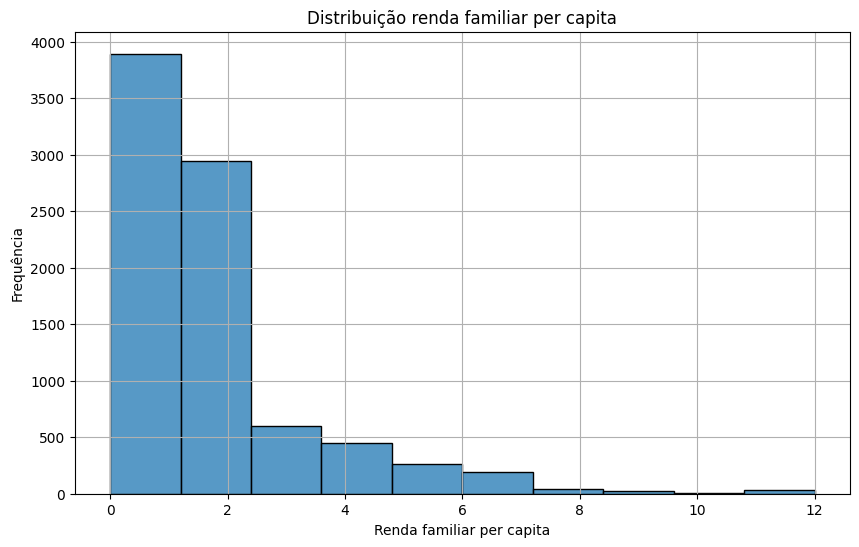

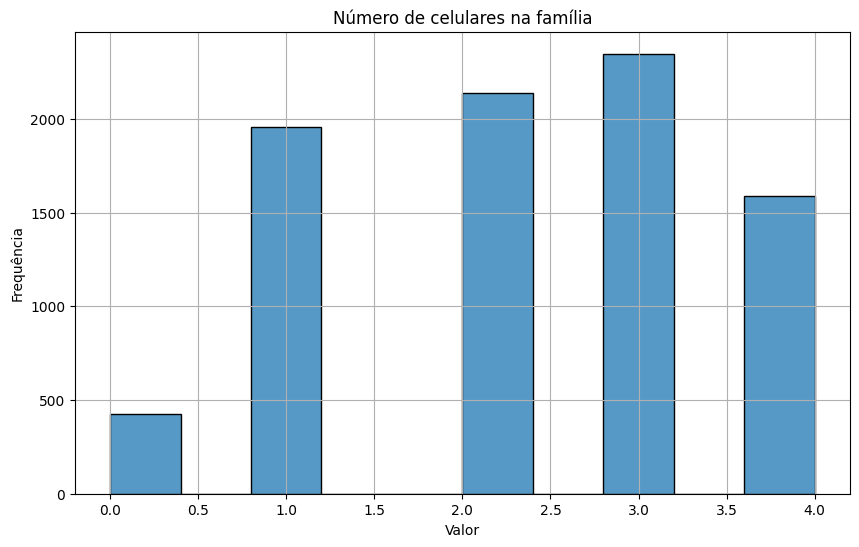

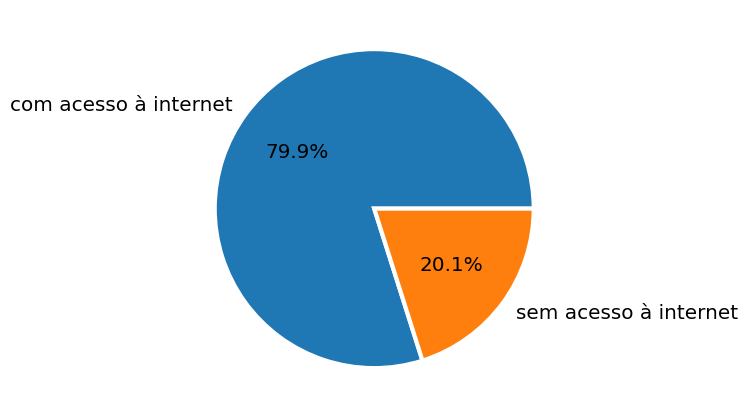

In [282]:
plt.figure(figsize=(10, 6))
sns.histplot(df22['faixa_per_capita_fam'], bins=10, kde=False)
plt.title('Distribuição renda familiar per capita')
plt.xlabel('Renda familiar per capita')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df22['Q022'], bins=10, kde=False)
plt.title('Número de celulares na família')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

plt.pie([df22['Q025'].sum(), len(df22) - df22['Q025'].sum()], labels = ['com acesso à internet', 'sem acesso à internet'], autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.tight_layout()

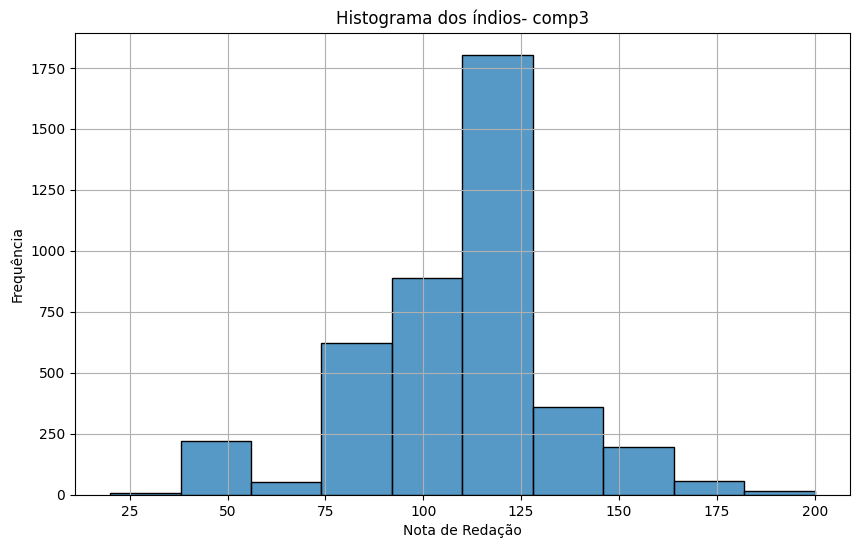

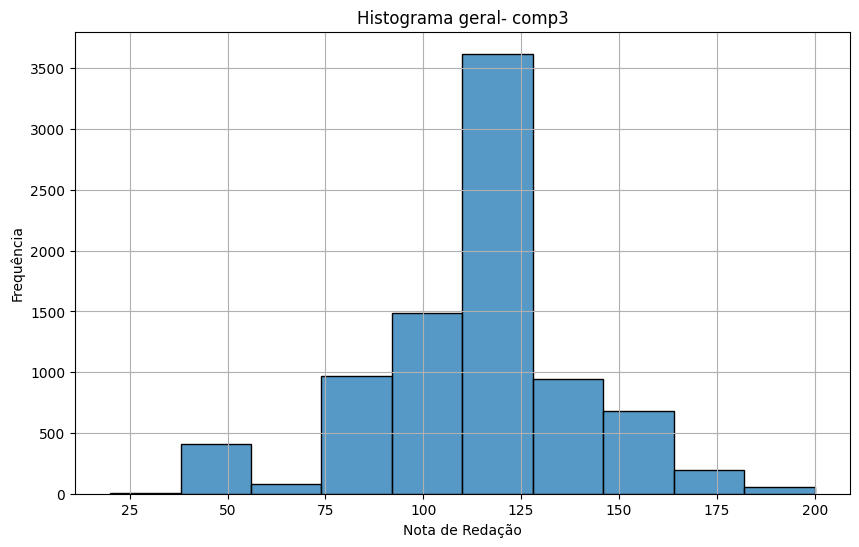

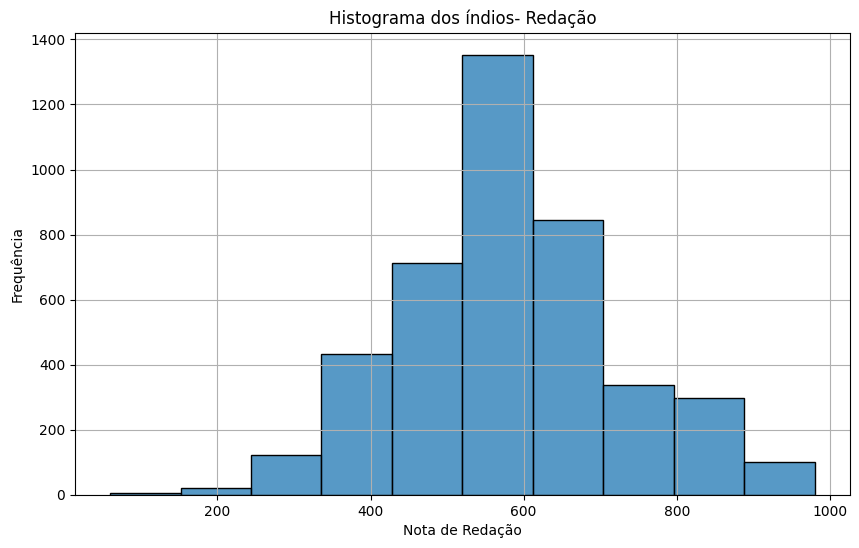

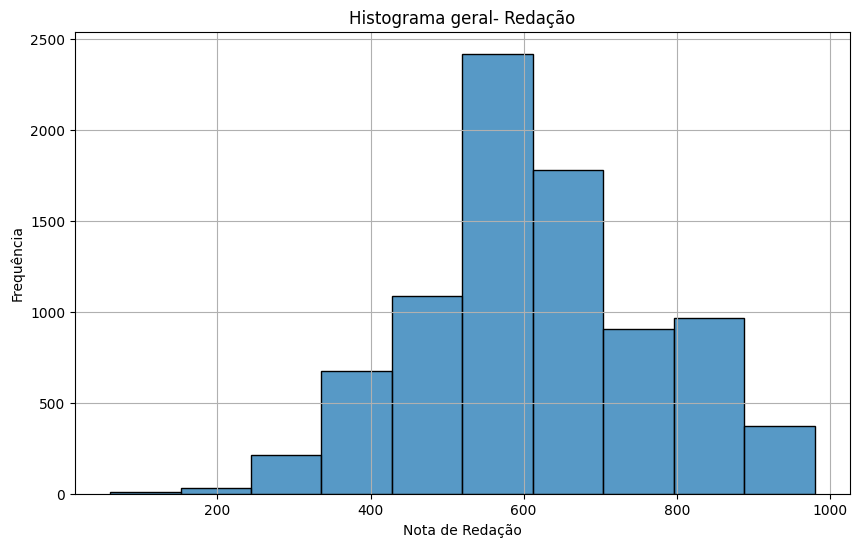

In [283]:
# apenas vendo se as notas seguem uma normal
# A nota da comp3 segue melhor a normal, entao usaremos ela para modelagem

def nota_grupo(dados_grupo, info, nota):
    plt.figure(figsize=(10, 6))
    # sns.kdeplot(dados_grupo['NU_NOTA_COMP3'], bw_adjust=2)
    sns.histplot(dados_grupo[nota], bins=10, kde=False)
    plt.title(info)
    plt.xlabel('Nota de Redação')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

nota_grupo(df22[df22['TP_COR_RACA_5']== True], 'Histograma dos índios- comp3', 'NU_NOTA_COMP3')
nota_grupo(df22, 'Histograma geral- comp3', 'NU_NOTA_COMP3')
nota_grupo(df22[df22['TP_COR_RACA_5']== True], 'Histograma dos índios- Redação', 'NU_NOTA_REDACAO')
nota_grupo(df22, 'Histograma geral- Redação', 'NU_NOTA_REDACAO')

In [284]:
media_geral = df22['NU_NOTA_REDACAO'].mean()
print(f'indigenas que tiraram acima da média:  {dados_indigenas['NU_NOTA_REDACAO'].gt(media_geral).sum()/len(df22)}')
print(f'nao indigenas que tiraram acima da média:  {dados_nao_indigenas['NU_NOTA_REDACAO'].gt(media_geral).sum()/len(df22)}')

indigenas que tiraram acima da média:  0.18985095812633074
nao indigenas que tiraram acima da média:  60.73468180742844


(analisando pre matching) Nota-se que a cada ano a diferença entre as curvas parece ser menor. O ano de 23 teve uma diferença significativamente menor que 21, apesar do tema raça/cor não ser algo relevante em ambos os anos, no que tange à própria prova. Vários fatores que aqui não conseguem ser medidos podem explicar essa redução da diferença da area entre as curvas ao longo dos anos: 
* **Redução da disparidade digital**: Tanto o aumento do acesso à internet quanto a melhoria da qualidade da internet em regiões afastadas contribuem para a redução da disparidade digital entre estudantes indígenas e não-indígenas. Isso pode ter permitido uma melhor preparação para a redação, especialmente para aqueles que anteriormente não tinham acesso a esses recursos. Indigenas, quando comparado a nao-indigenas, costumam morar em locais mais afastados, além de ter menor acesso a internet.

(pre x pos-matching) A diferença entre as curvas de indios e nao indios foi menor no ano de 22 e, alem disso, nota-se que essa diferença foi ainda mais reduzida após o matching. Esse maior impacto do matching em 2022 pode indicar que há fatores específicos nesse ano que influenciaram de maneira diferente a distribuição das notas de redação entre os grupos indígenas e não-indígenas. Nos outros anos, podemos observar que o matching nao teve um impacto significativo na área da diferença entre as curvas. O tema de 2022 sobre comunidades tradicionais pode ter sido particularmente relevante para os estudantes indígenas, mais do que para os não-indígenas. Isso pode ter reduzido as diferenças nas habilidades de redação quando os fatores sociais foram controlados pelo matching. Em outras palavras, o tema pode ter nivelado o campo de jogo de uma maneira que os outros temas de 2021 e 2023 não fizeram.

Os resultados indicam que o tema de redação de 2022 teve um impacto particular nas notas dos estudantes indígenas, sugerindo que temas culturalmente relevantes podem ajudar a reduzir disparidades de desempenho em avaliações. O matching exato reforça a validade dessas observações, mostrando que as características sociais foram bem balanceadas, e as diferenças observadas são atribuíveis principalmente ao tema da redação.

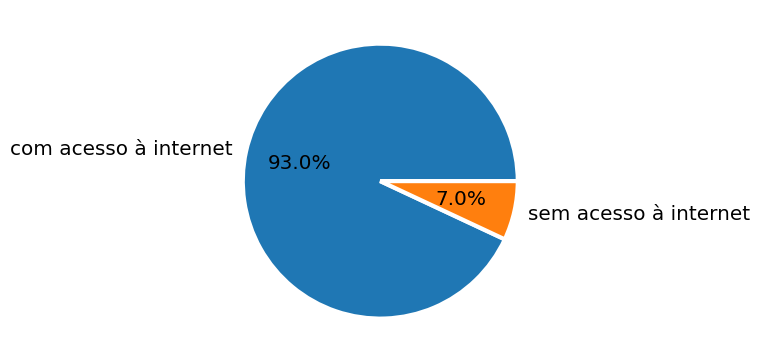

In [285]:
plt.pie([df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]['Q025'].sum(), len(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]) - df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]['Q025'].sum()], labels = ['com acesso à internet', 'sem acesso à internet'], autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.tight_layout()

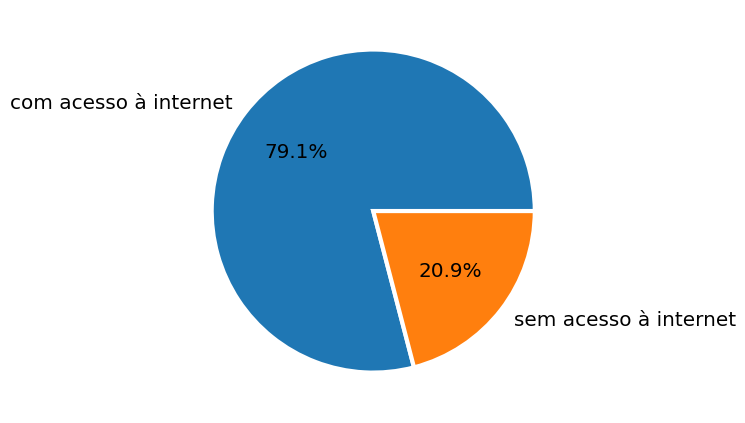

In [286]:
plt.pie([df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]['Q025'].sum(), len(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]) - df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]['Q025'].sum()], labels = ['com acesso à internet', 'sem acesso à internet'], autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.tight_layout()

A consistência das áreas antes e depois do ponto de interseção ao longo dos anos (tanto com quanto sem matching) sugere que há um padrão estável nas distribuições de notas de redação entre indígenas e não-indígenas. Este padrão é alterado apenas marginalmente pelo tema da redação de 2022, o que reforça a ideia de que o tema pode ter sido particularmente relevante para os indígenas.

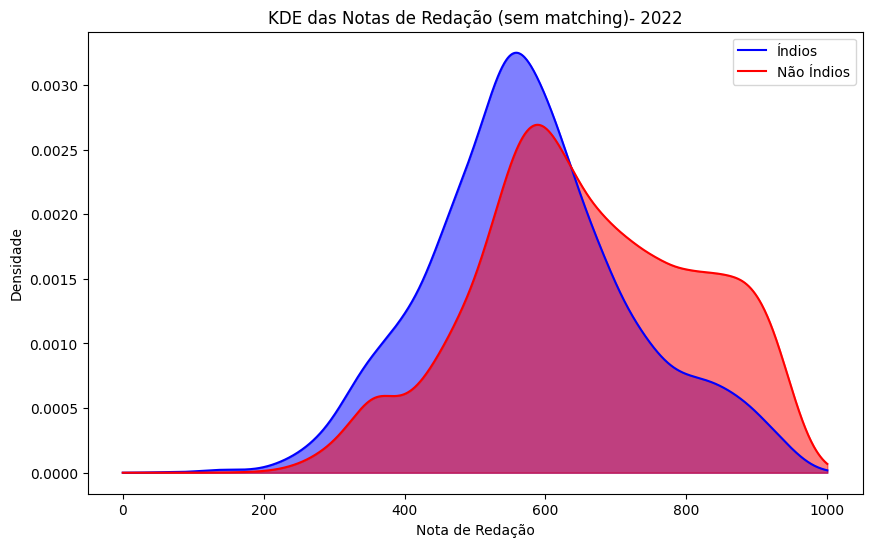

Crossing Point: 635.64
Area Before: 0.214
Area After: 0.214


C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\4192396355.py:42: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\4192396355.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]


In [287]:
kde_indios = gaussian_kde(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]['NU_NOTA_REDACAO'])
kde_nao_indios = gaussian_kde(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]['NU_NOTA_REDACAO'], bw_method=0.15)

# Gerar valores para o eixo x
x_vals = np.linspace(0, 1000, 1000)

# Calcular as densidades KDE
kde_indios_data = kde_indios(x_vals)
kde_nao_indios_data = kde_nao_indios(x_vals)

# Interpolação das curvas KDE
kde_indios_interp = interp1d(x_vals, kde_indios_data, bounds_error=False, fill_value="extrapolate")
kde_nao_indios_interp = interp1d(x_vals, kde_nao_indios_data, bounds_error=False, fill_value="extrapolate")

# Plotar as curvas KDE
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_indios_data, color='blue', label='Índios')
plt.plot(x_vals, kde_nao_indios_data, color='red', label='Não Índios')
plt.fill_between(x_vals, kde_indios_data, alpha=0.5, color='blue')
plt.fill_between(x_vals, kde_nao_indios_data, alpha=0.5, color='red')
plt.title('KDE das Notas de Redação (sem matching)- 2022')
plt.xlabel('Nota de Redação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# Função para calcular a área entre as curvas
def area_between_curves(x, kde1, kde2):
    return abs(kde1(x) - kde2(x))

# Encontrar o ponto de cruzamento no intervalo relevante (notas entre 0 e 1000)
diffs = kde_nao_indios_interp(x_vals) - kde_indios_interp(x_vals)
crossing_points = x_vals[np.where(np.diff(np.sign(diffs)))[0]]

if len(crossing_points) == 0:
    print('No crossing points found in the range.')
else:
    crossing_point = crossing_points[0]  # Usar o primeiro ponto de cruzamento relevante
    print(f'Crossing Point: {crossing_point:.2f}')

    # Calcular área antes e depois do ponto de cruzamento
    area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
    area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]

    print(f'Area Before: {area_before:.3f}')
    print(f'Area After: {area_after:.3f}')

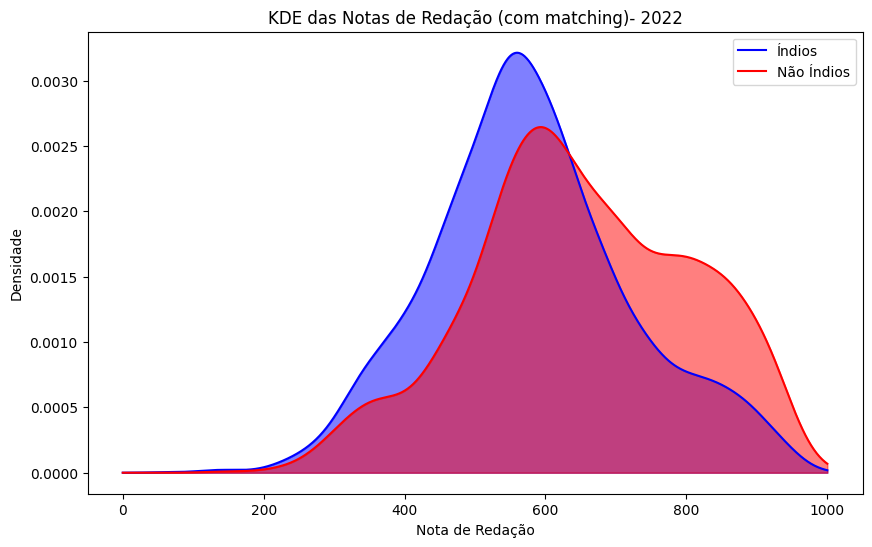

Crossing Point: 632.63
Area Before: 0.204
Area After: 0.203


C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\952320704.py:42: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\952320704.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]


In [288]:
kde_indios = gaussian_kde(df22[df22['TP_COR_RACA_5'] == True]['NU_NOTA_REDACAO'])
kde_nao_indios = gaussian_kde(df22[df22['TP_COR_RACA_5'] == False]['NU_NOTA_REDACAO'])

# Gerar valores para o eixo x
x_vals = np.linspace(0, 1000, 1000)

# Calcular as densidades KDE
kde_indios_data = kde_indios(x_vals)
kde_nao_indios_data = kde_nao_indios(x_vals)

# Interpolação das curvas KDE
kde_indios_interp = interp1d(x_vals, kde_indios_data, bounds_error=False, fill_value="extrapolate")
kde_nao_indios_interp = interp1d(x_vals, kde_nao_indios_data, bounds_error=False, fill_value="extrapolate")

# Plotar as curvas KDE
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_indios_data, color='blue', label='Índios')
plt.plot(x_vals, kde_nao_indios_data, color='red', label='Não Índios')
plt.fill_between(x_vals, kde_indios_data, alpha=0.5, color='blue')
plt.fill_between(x_vals, kde_nao_indios_data, alpha=0.5, color='red')
plt.title('KDE das Notas de Redação (com matching)- 2022')
plt.xlabel('Nota de Redação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# Função para calcular a área entre as curvas
def area_between_curves(x, kde1, kde2):
    return abs(kde1(x) - kde2(x))

# Encontrar o ponto de cruzamento no intervalo relevante (notas entre 0 e 1000)
diffs = kde_nao_indios_interp(x_vals) - kde_indios_interp(x_vals)
crossing_points = x_vals[np.where(np.diff(np.sign(diffs)))[0]]

if len(crossing_points) == 0:
    print('No crossing points found in the range.')
else:
    crossing_point = crossing_points[0]  # Usar o primeiro ponto de cruzamento relevante
    print(f'Crossing Point: {crossing_point:.2f}')

    # Calcular área antes e depois do ponto de cruzamento
    area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
    area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]

    print(f'Area Before: {area_before:.3f}')
    print(f'Area After: {area_after:.3f}')

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\832843346.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22['TP_COR_RACA_5']==True]['NU_NOTA_COMP3'], color='blue', shade=True, label='Índios')
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\832843346.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22['TP_COR_RACA_5']==False]['NU_NOTA_COMP3'], color='red', shade=True, label='Não Índios')


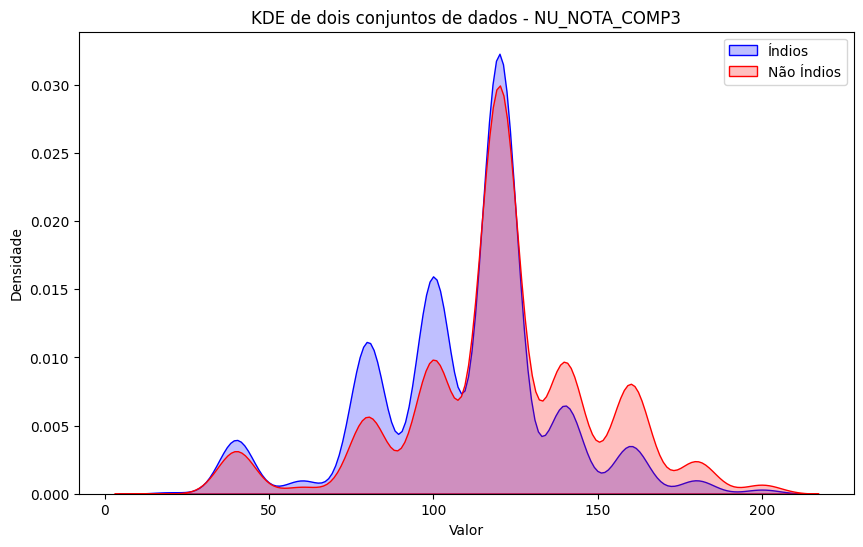

In [289]:
# Criar o gráfico KDE para NU_NOTA_COMP3
plt.figure(figsize=(10, 6))
sns.kdeplot(df22[df22['TP_COR_RACA_5']==True]['NU_NOTA_COMP3'], color='blue', shade=True, label='Índios')
sns.kdeplot(df22[df22['TP_COR_RACA_5']==False]['NU_NOTA_COMP3'], color='red', shade=True, label='Não Índios')
plt.title('KDE de dois conjuntos de dados - NU_NOTA_COMP3')
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.legend()
plt.show()

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\4181574789.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=1.5)
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\4181574789.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=1.5)
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\4181574789.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=

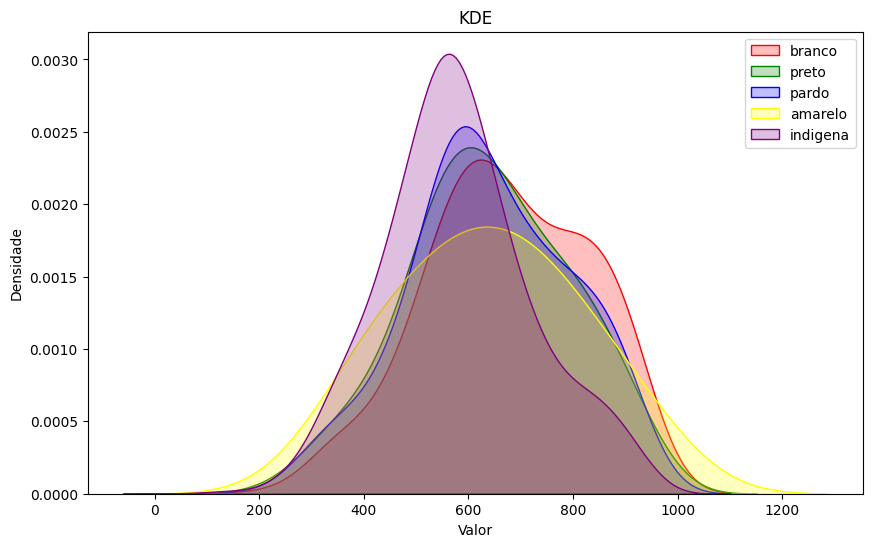

[1401, 604, 2151, 71, 4227]


In [290]:
# Definindo as cores e labels para cada grupo
cores = ['red', 'green', 'blue', 'yellow', 'purple']
labels = ['branco', 'preto', 'pardo', 'amarelo', 'indigena']
colunas_raca = ['TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5']

# Lista para armazenar os comprimentos
lengths = []

# Criar o gráfico KDE com Seaborn
plt.figure(figsize=(10, 6))

# Loop através das colunas de raça
for cor, label, coluna in zip(cores, labels, colunas_raca):
    sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=1.5)
    lengths.append(len(df22[df22[coluna]==True]['NU_NOTA_REDACAO']))

# Adicionar título e rótulos
plt.title('KDE')
plt.xlabel('Valor')
plt.ylabel('Densidade')

# Adicionar legenda
plt.legend()

# Mostrar o gráfico
plt.show()

print(lengths)

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\351127799.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x='TP_COR_RACA_5', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


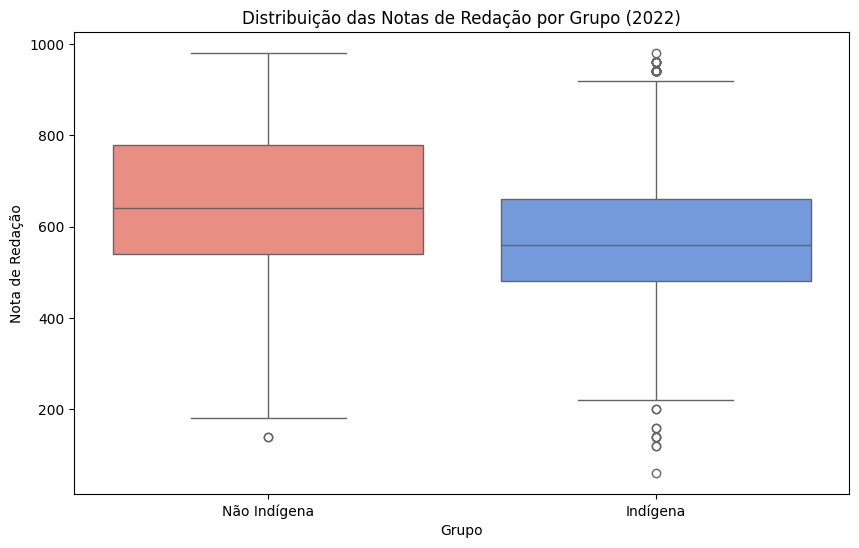

In [311]:
# Boxplot das notas de redação
# O tema de 2022 sobre comunidades tradicionais não parece ter tido um impacto significativo nas notas de redação dos estudantes indígenas comparado aos anos anteriores e seguintes.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df22, x='TP_COR_RACA_5', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
plt.title('Distribuição das Notas de Redação por Grupo (2022)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.xticks([0, 1], ['Não Indígena', 'Indígena'])
plt.show()

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\4270446186.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x='Q025', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


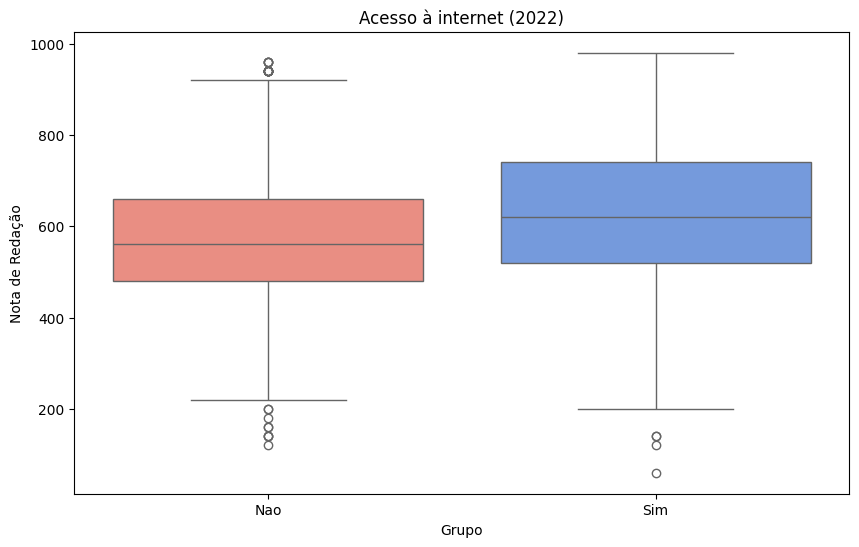

In [292]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df22, x='Q025', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
plt.title('Acesso à internet (2022)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.xticks([0, 1], ['Nao', 'Sim'])
plt.show()

In [293]:
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'NU_NOTA_COMP3',
       'NU_NOTA_REDACAO', 'Q022', 'Q025', 'TP_COR_RACA_1', 'TP_COR_RACA_2',
       'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5', 'CAPITAL',
       'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul', 'faixa_per_capita_fam',
       'responsavel_maior_escolaridade', 'responsavel_maior_emprego'],
      dtype='object')


C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: UserWarning: 
The palette list has fewer values (2) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


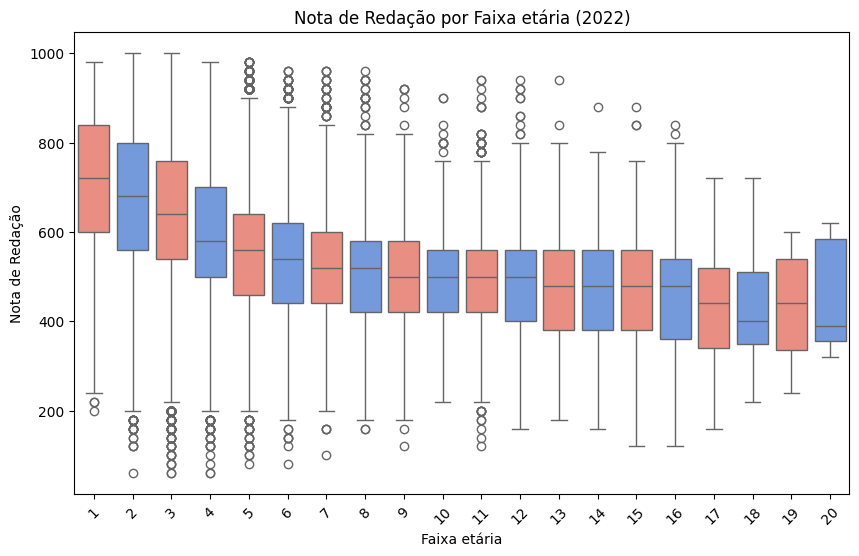

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


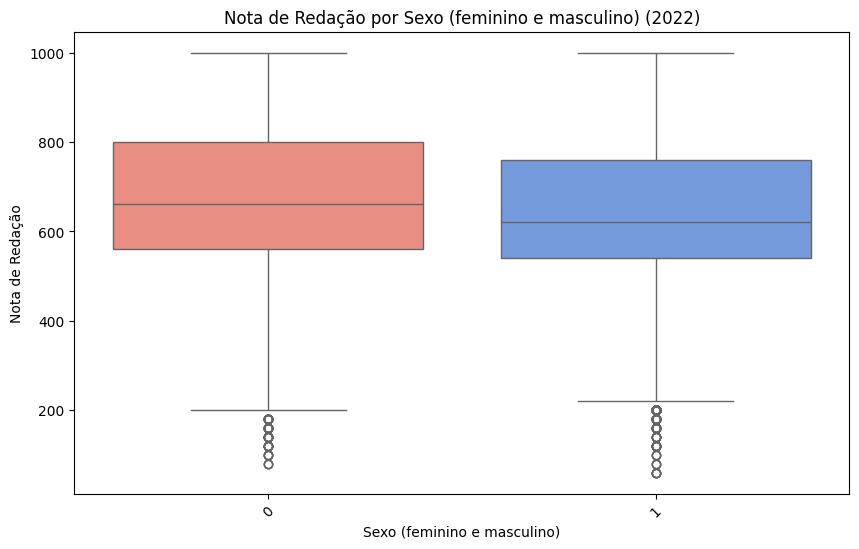

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


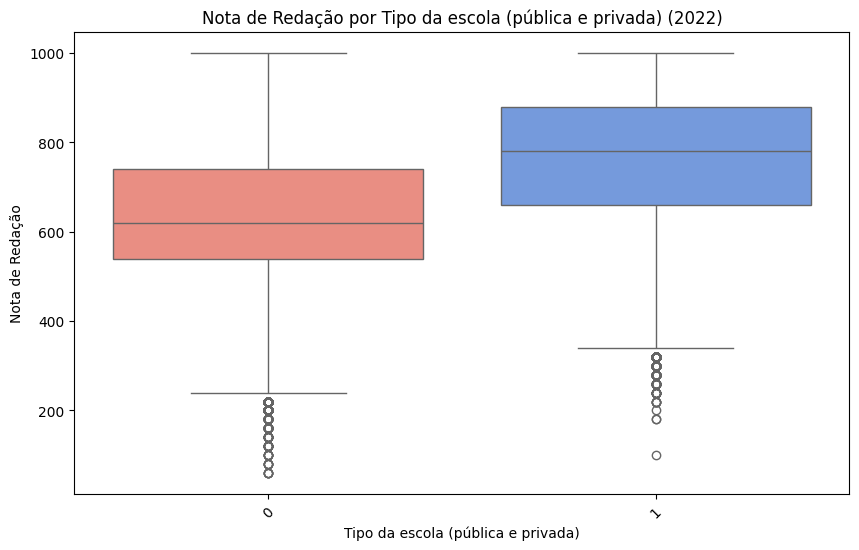

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


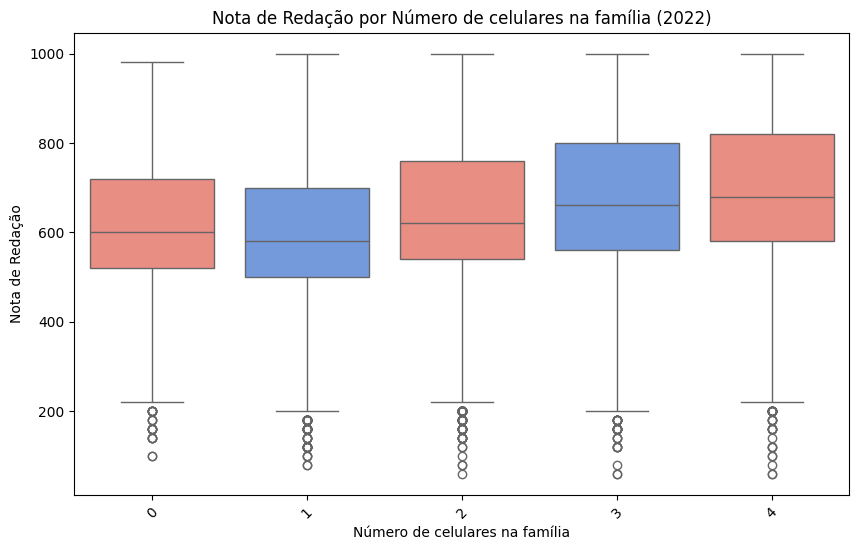

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


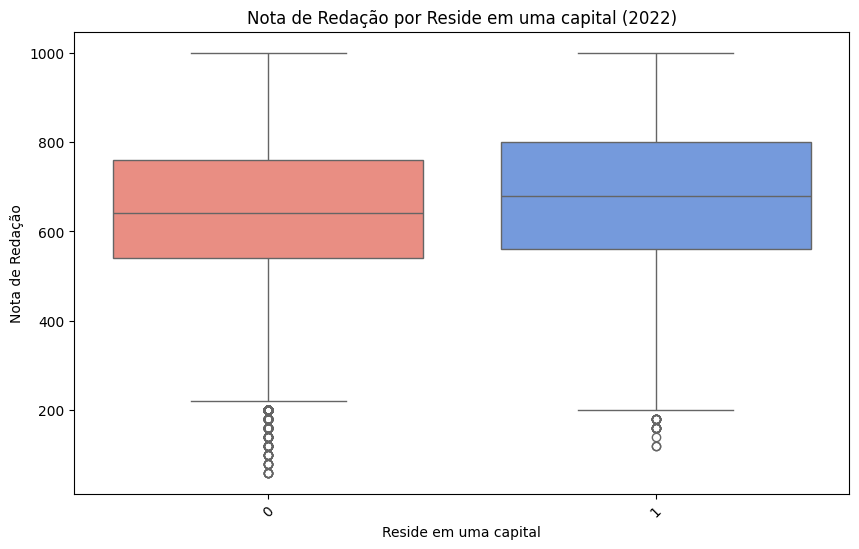

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: UserWarning: 
The palette list has fewer values (2) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


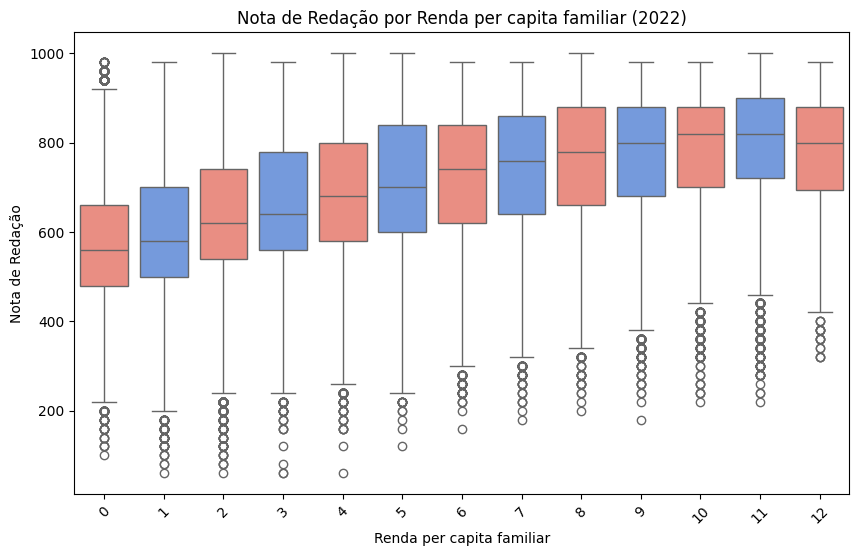

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: UserWarning: 
The palette list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


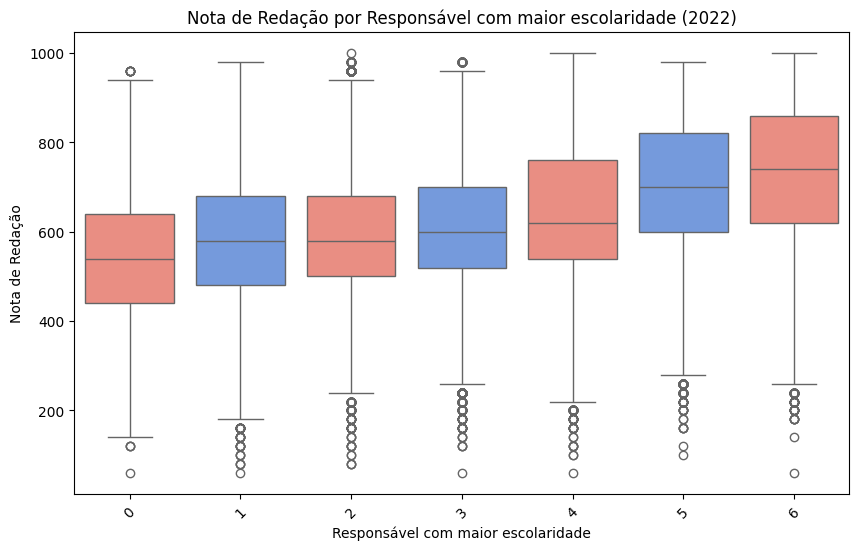

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


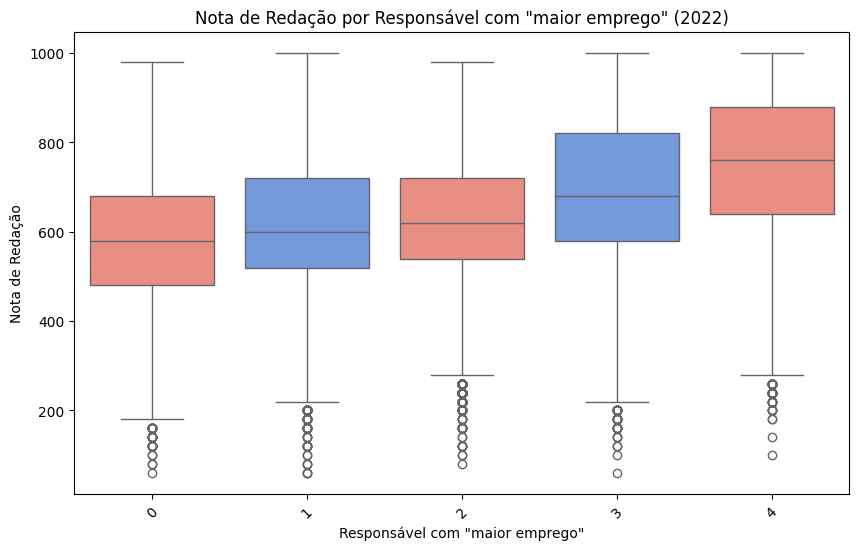

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


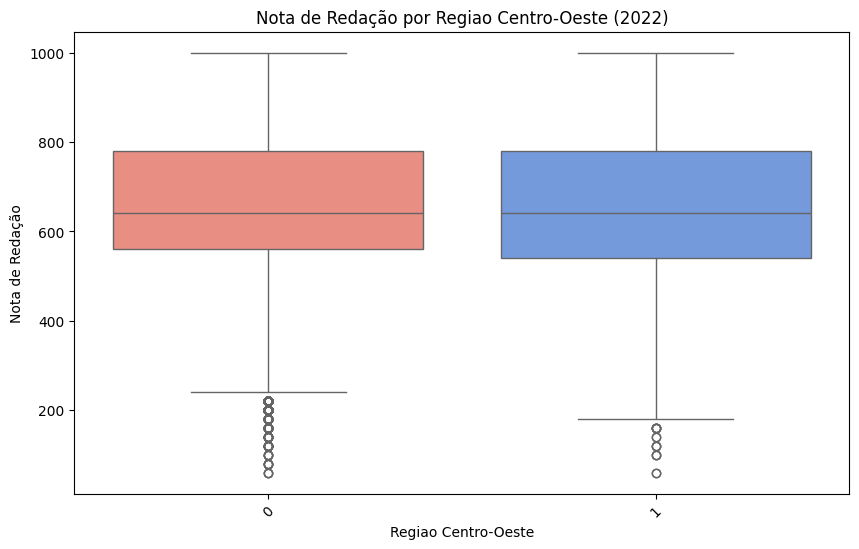

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


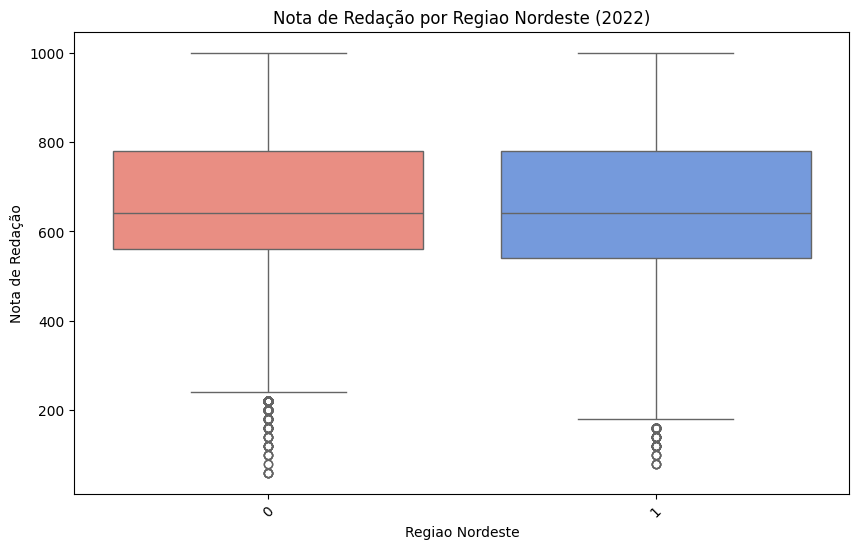

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


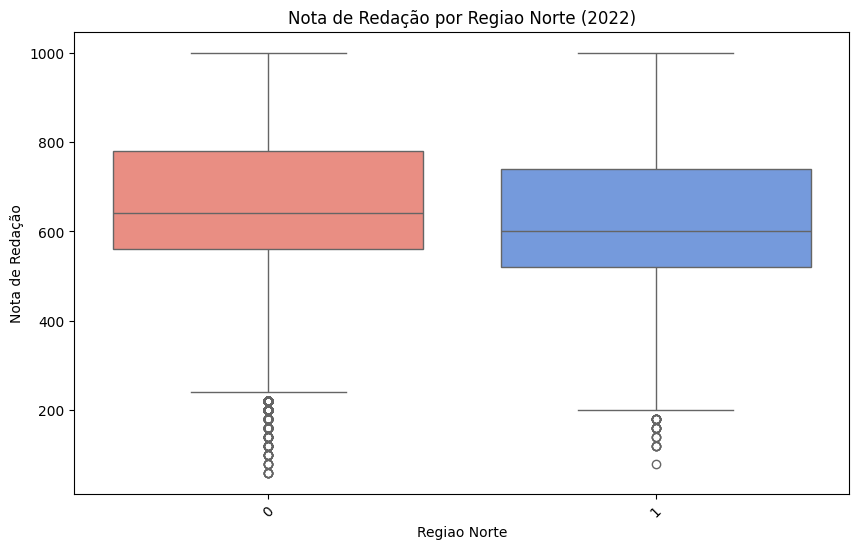

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


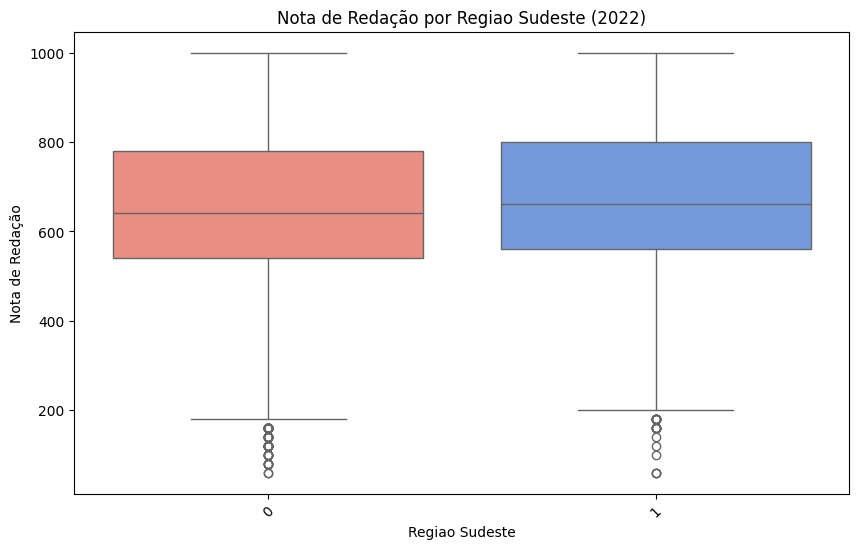

C:\Users\b47244\AppData\Local\Temp\ipykernel_23088\2204020929.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


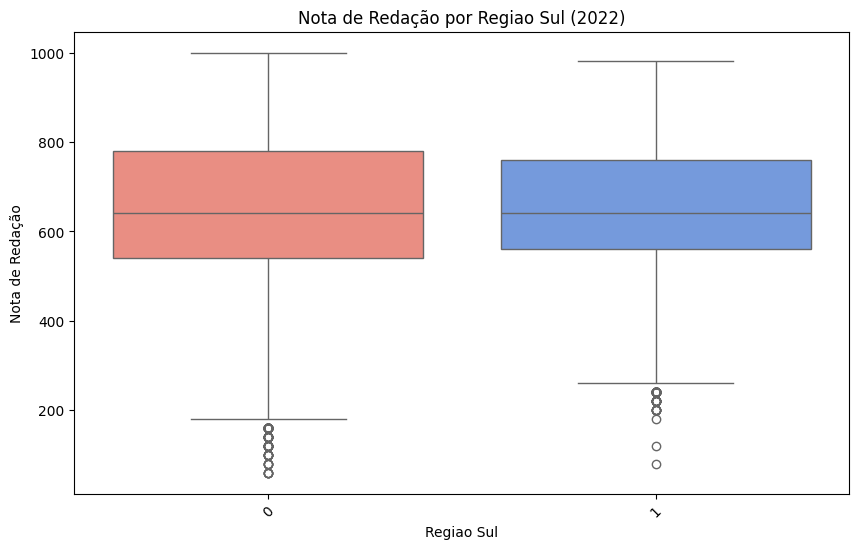

In [294]:
# Lista de variáveis de interesse para o eixo x
variaveis = ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'Q022', 'CAPITAL', 'faixa_per_capita_fam',
       'responsavel_maior_escolaridade', 'responsavel_maior_emprego', 'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul']
variaveis_nomes = ['Faixa etária', 'Sexo (feminino e masculino)', 'Tipo da escola (pública e privada)',
                    'Número de celulares na família', 'Reside em uma capital', 'Renda per capita familiar', 'Responsável com maior escolaridade',
                     'Responsável com "maior emprego"', 'Regiao Centro-Oeste', 'Regiao Nordeste', 'Regiao Norte', 'Regiao Sudeste', 'Regiao Sul']

# Loop para criar e exibir cada gráfico separadamente
for i, variavel in enumerate(variaveis):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df22_sem_match, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
    plt.title(f'Nota de Redação por {variaveis_nomes[i]} (2022)')
    plt.xlabel(variaveis_nomes[i])
    plt.ylabel('Nota de Redação')
    plt.xticks(rotation=45)  # Rotação dos rótulos se necessário
    plt.show()


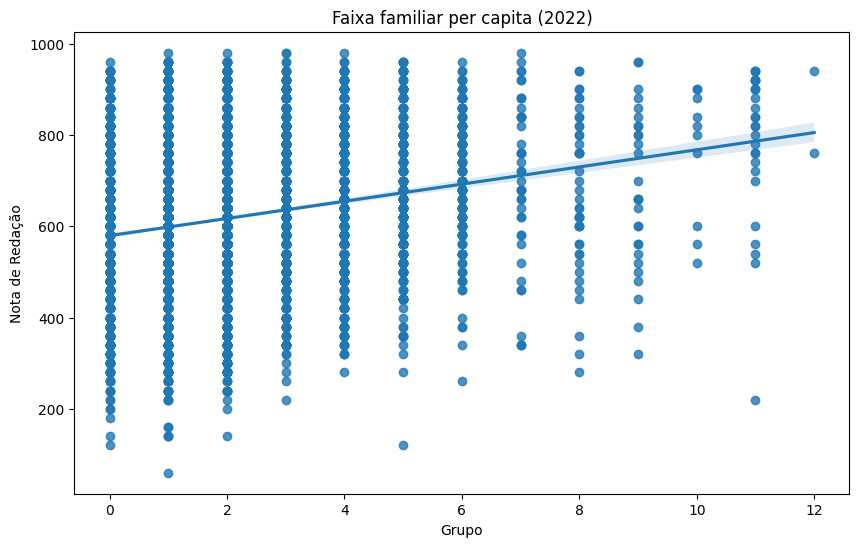

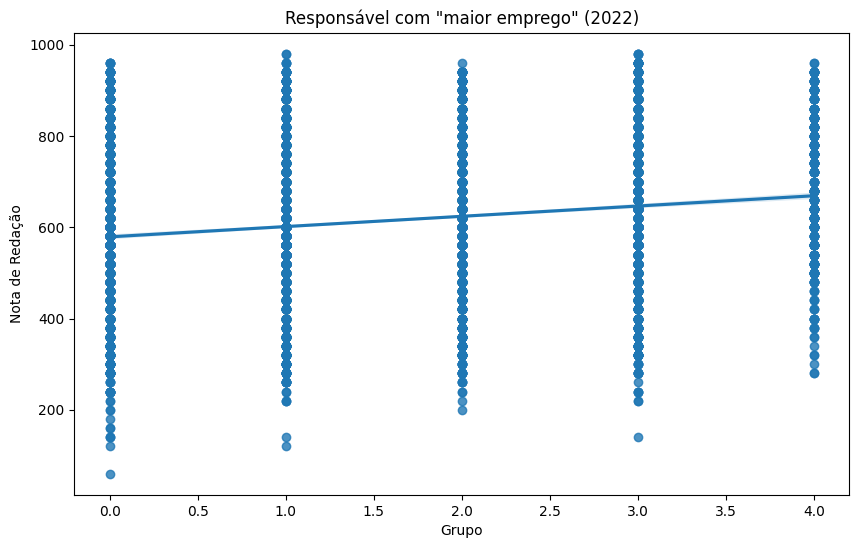

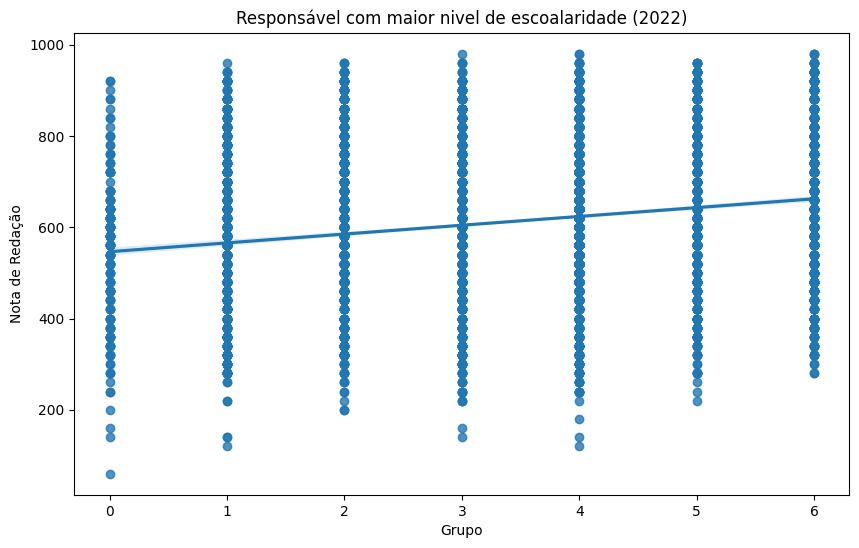

In [295]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='faixa_per_capita_fam', y='NU_NOTA_REDACAO')
plt.title('Faixa familiar per capita (2022)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='responsavel_maior_emprego', y='NU_NOTA_REDACAO')
plt.title('Responsável com "maior emprego" (2022)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='responsavel_maior_escolaridade', y='NU_NOTA_REDACAO')
plt.title('Responsável com maior nivel de escoalaridade (2022)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.show()

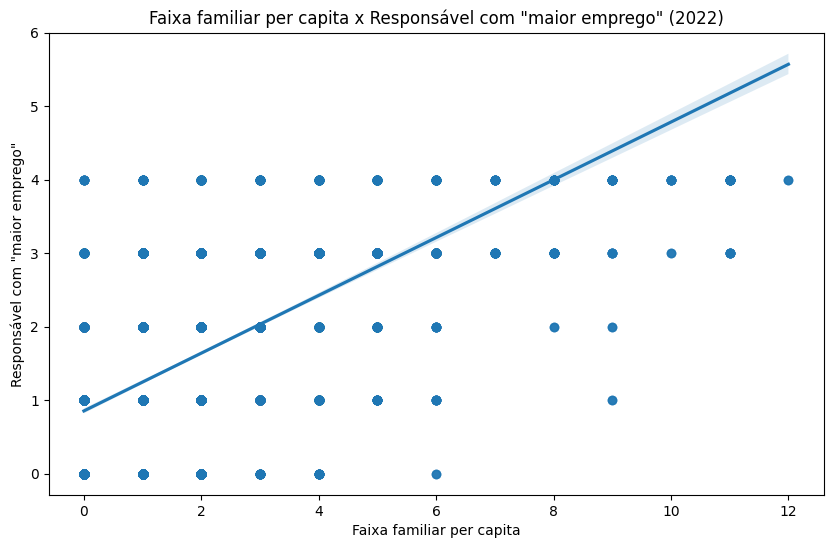

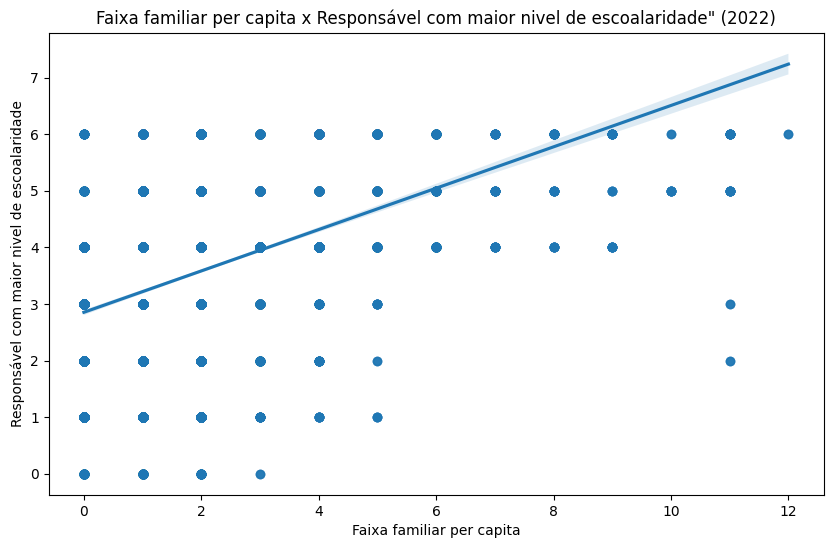

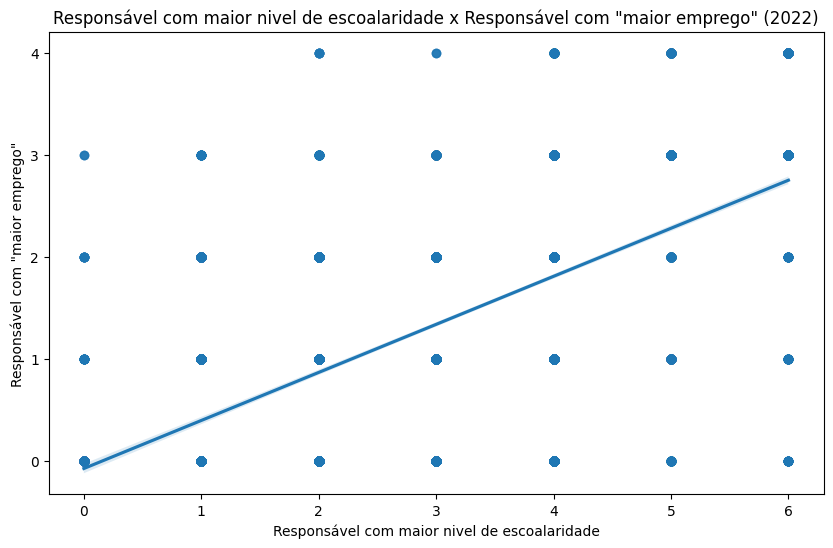

In [296]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='faixa_per_capita_fam', y='responsavel_maior_emprego')
plt.title('Faixa familiar per capita x Responsável com "maior emprego" (2022)')
plt.xlabel('Faixa familiar per capita')
plt.ylabel('Responsável com "maior emprego"')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='faixa_per_capita_fam', y='responsavel_maior_escolaridade')
plt.title('Faixa familiar per capita x Responsável com maior nivel de escoalaridade" (2022)')
plt.xlabel('Faixa familiar per capita')
plt.ylabel('Responsável com maior nivel de escoalaridade')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='responsavel_maior_escolaridade', y='responsavel_maior_emprego')
plt.title('Responsável com maior nivel de escoalaridade x Responsável com "maior emprego" (2022)')
plt.xlabel('Responsável com maior nivel de escoalaridade')
plt.ylabel('Responsável com "maior emprego"')
plt.show()

A análise das correlações ajuda na regressão linear de várias maneiras:

*Identificação de Variáveis Relevantes*: Ao examinar as correlações entre as variáveis independentes e a variável dependente, você pode identificar quais variáveis têm uma relação mais forte com a variável de interesse. Isso ajuda na seleção das variáveis a serem incluídas no modelo de regressão.

*Prevenção de Multicolinearidade*: A análise das correlações entre as variáveis independentes pode ajudar a identificar a multicolinearidade, que ocorre quando duas ou mais variáveis independentes estão altamente correlacionadas entre si. A multicolinearidade pode prejudicar a interpretação dos coeficientes de regressão e a precisão das previsões.

*Validação de Suposiçõe*s: A regressão linear assume certas condições, como linearidade, homocedasticidade e independência dos erros. Ao examinar as correlações, você pode verificar se essas suposições estão sendo violadas. Por exemplo, se houver uma correlação não linear entre as variáveis, pode ser necessário considerar transformações das variáveis.

*Interpretação dos Coeficientes*: As correlações podem fornecer insights sobre a direção e a magnitude das associações entre as variáveis independentes e a variável dependente. Isso ajuda na interpretação dos coeficientes de regressão no modelo final.

Em resumo, a análise das correlações é uma etapa importante no processo de modelagem de regressão linear, pois ajuda a selecionar variáveis relevantes, evitar problemas como multicolinearidade e validar suposições do modelo. Isso leva a um modelo de regressão mais robusto e confiável.

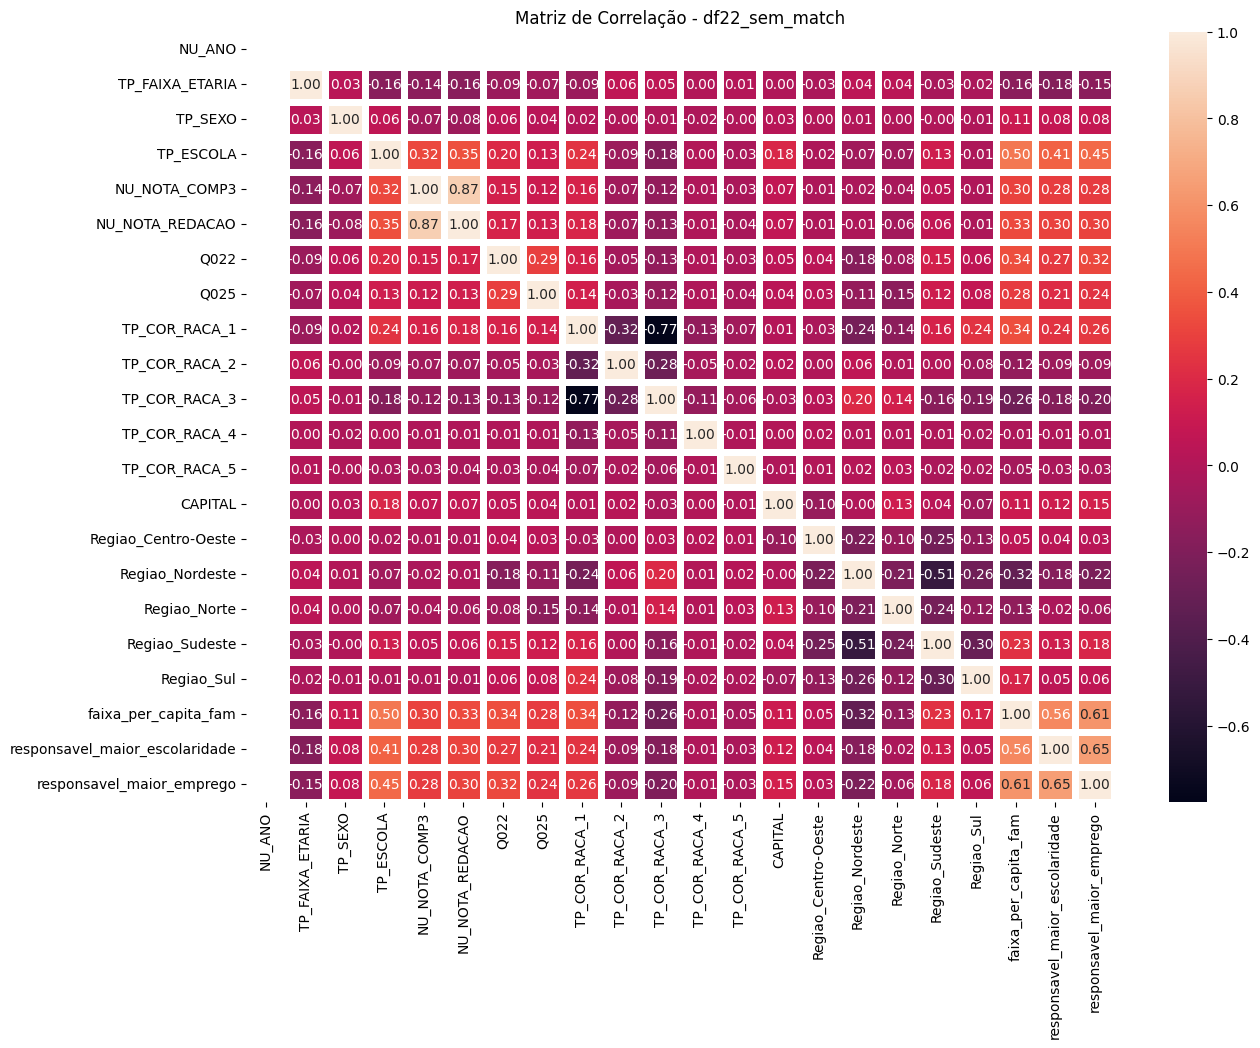

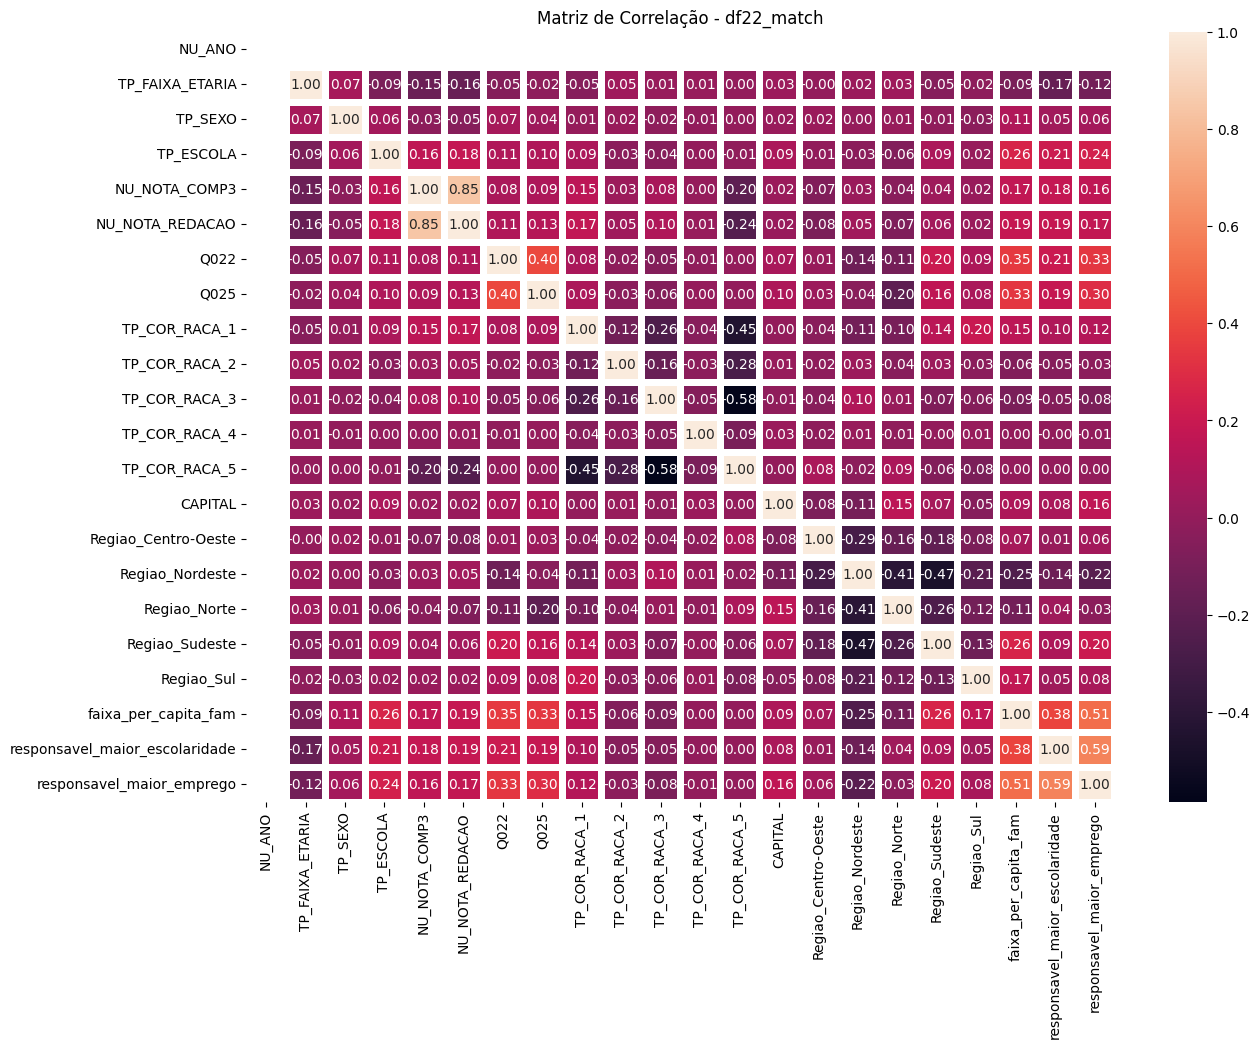

In [297]:
# nota-se que a correlação da cor/raça indigena com a nota da redação foi menos negativa em 22 e o valor da variavel indio se torna mais significativa

plt.figure(figsize=(14, 10))
# Plot da matriz de correlação para df22
plot1 = sns.heatmap(df22_sem_match.corr(method='spearman'), annot=True, fmt="0.2f", linewidths=5)
plt.title('Matriz de Correlação - df22_sem_match')
# Exibir o plot1
plt.show()


plt.figure(figsize=(14, 10))
# Plot da matriz de correlação para df22_match
plot2 = sns.heatmap(df22.corr(method='spearman'), annot=True, fmt="0.2f", linewidths=5)
plt.title('Matriz de Correlação - df22_match')
# Exibir o plot2
plt.show()

# Modelos

Modelos:
* regressão linear x multinivel
* nota da redação x nota da competencia 3
* todas as variaveis
* variaveis relevantes
* exlcuindo as com correlação muito alta
* indio ou nao-indio apenas


In [298]:
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'NU_NOTA_COMP3',
       'NU_NOTA_REDACAO', 'Q022', 'Q025', 'TP_COR_RACA_1', 'TP_COR_RACA_2',
       'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5', 'CAPITAL',
       'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul', 'faixa_per_capita_fam',
       'responsavel_maior_escolaridade', 'responsavel_maior_emprego'],
      dtype='object')


In [299]:
def combine_race(row):
    if row['TP_COR_RACA_1'] == 1:
        return '1'
    elif row['TP_COR_RACA_2'] == 1:
        return '2'
    elif row['TP_COR_RACA_3'] == 1:
        return '3'
    elif row['TP_COR_RACA_4'] == 1:
        return '4'
    elif row['TP_COR_RACA_5'] == 1:
        return '5'
    else:
        return 'Unknown'
    
def combine_regiao(row):
    if row['Regiao_Centro-Oeste'] == 1:
        return '1'
    elif row['Regiao_Nordeste'] == 1:
        return '2'
    elif row['Regiao_Norte'] == 1:
        return '3'
    elif row['Regiao_Sudeste'] == 1:
        return '4'
    elif row['Regiao_Sul'] == 1:
        return '5'
    else:
        return 'Unknown'

In [300]:
# Modelo 1: Regressao linear, nota da redação, todas as variaveis

df22_modelo1 = df22.copy()

df22_modelo1['TP_COR_RACA'] = df22_modelo1.apply(combine_race, axis=1)
df22_modelo1['Regiao'] = df22_modelo1.apply(combine_regiao, axis=1)

# Dividir os dados
train, test = train_test_split(df22_modelo1, test_size=0.2, random_state=42)

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + TP_ESCOLA + Q022 + Q025 + C(TP_COR_RACA) + C(Regiao) \
    + CAPITAL + faixa_per_capita_fam + responsavel_maior_escolaridade + responsavel_maior_emprego'

# Ajustar o modelo de regressão linear usando os dados de treinamento
model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     74.43
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          3.16e-236
Time:                        10:57:25   Log-Likelihood:                -43100.
No. Observations:                6763   AIC:                         8.624e+04
Df Residuals:                    6745   BIC:                         8.636e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [301]:
# Modelo 2: Regressao linear, nota da redação, excluindo com correlação muito baixa com a variavel resposta (sexo, ano que concluiu, capital)

# ainda usando df22_modelo1

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + Q022 + Q025 + C(TP_COR_RACA) + C(Regiao) \
    + faixa_per_capita_fam + responsavel_maior_escolaridade + responsavel_maior_emprego'

# Ajustar o modelo de regressão linear usando os dados de treinamento
model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     80.30
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          2.86e-213
Time:                        10:57:25   Log-Likelihood:                -43161.
No. Observations:                6763   AIC:                         8.635e+04
Df Residuals:                    6748   BIC:                         8.645e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [302]:
# Modelo 3: Regressao linear, nota da redação, excluindo com correlação muito alta com a variavel independente (ano que concluiu, renda familiar per capita, responsavel de maior emprego)

# ainda usando df22_modelo1

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + Q022 + Q025 + C(TP_COR_RACA) + C(Regiao) \
    + CAPITAL + responsavel_maior_escolaridade'
# Ajustar o modelo de regressão linear usando os dados de treinamento
model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     72.82
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          7.41e-194
Time:                        10:57:26   Log-Likelihood:                -43206.
No. Observations:                6763   AIC:                         8.644e+04
Df Residuals:                    6748   BIC:                         8.654e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [303]:
# Modelo 4: Regressao linear, nota da redação, indio ou nao indio apenas

df22_modelo4 = df22.copy()

df22_modelo4['Regiao'] = df22_modelo4.apply(combine_regiao, axis=1)

# Dividir os dados
train, test = train_test_split(df22_modelo4, test_size=0.2, random_state=42)

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + TP_ESCOLA + Q022 + Q025 + TP_COR_RACA_5 + C(Regiao) \
    + CAPITAL + faixa_per_capita_fam + responsavel_maior_escolaridade + responsavel_maior_emprego'

model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     89.61
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          4.29e-237
Time:                        10:57:26   Log-Likelihood:                -43105.
No. Observations:                6763   AIC:                         8.624e+04
Df Residuals:                    6748   BIC:                         8.634e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [304]:
import statsmodels.formula.api as smf
import numpy as np

# Definição da fórmula
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + TP_ESCOLA + Q022 + Q025 + TP_COR_RACA_5 + C(Regiao) \
    + CAPITAL + faixa_per_capita_fam + responsavel_maior_escolaridade + responsavel_maior_emprego'

# Criação de uma cópia do DataFrame
df_multinivel = df22.copy()

df_multinivel['Regiao'] = df_multinivel.apply(combine_regiao, axis=1)

# Ajustar o modelo multinível
model_multinivel = smf.mixedlm(formula, data=df_multinivel, groups=df_multinivel['TP_COR_RACA_5']).fit()

# Exibir os resultados
print(model_multinivel.summary())

# Predição dos valores ajustados
y_pred = model_multinivel.fittedvalues

# Valores reais
y_real = df_multinivel['NU_NOTA_REDACAO']

# Cálculo do R²
ss_total = np.sum((y_real - np.mean(y_real)) ** 2)
ss_residual = np.sum((y_real - y_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Cálculo do erro absoluto
mae = np.mean(np.abs(y_real - y_pred))

print(f'R²: {r_squared}')
print(f'Mean Absolute Error: {mae}')


                     Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       NU_NOTA_REDACAO
No. Observations:        8454          Method:                   REML           
No. Groups:              2             Scale:                    19970.7595     
Min. group size:         4227          Log-Likelihood:           -53815.0186    
Max. group size:         4227          Converged:                Yes            
Mean group size:         4227.0                                                 
--------------------------------------------------------------------------------
                                 Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------
Intercept                        594.189  141.576   4.197 0.000  316.704 871.673
C(Regiao)[T.2]                    50.923    5.442   9.358 0.000   40.258  61.588
C(Regiao)[T.3]                    28.190    6.177 

C:\Users\b47244\AppData\Roaming\Python\Python312\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [305]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df22[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA',
        'Q022', 'Q025', 'TP_COR_RACA_1',
       'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5',
       'CAPITAL', 'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul', 'faixa_per_capita_fam',
       'responsavel_maior_escolaridade', 'responsavel_maior_emprego']].copy()

Y = df22['NU_NOTA_REDACAO'].copy()

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)

reg = LinearRegression()
# Treinando o modelo
model1 =  reg.fit(X_train, y_train)
# Prevendo os dados de saída com o modelo treinado 
y_pred = model1.predict(X_test)
# Aqui plotamos os coeficientes da nossa regressão
reg.coef_

array([-1.61781026e+01, -2.43249168e+01,  7.65970888e+01,  3.33260470e+00,
        2.03707893e+01,  5.72624655e+13,  5.72624655e+13,  5.72624655e+13,
        5.72624655e+13,  5.72624655e+13, -5.03385828e+00,  1.81781252e+15,
        1.81781252e+15,  1.81781252e+15,  1.81781252e+15,  1.81781252e+15,
        9.42307204e+00,  8.61824471e+00,  4.83394999e+00])

In [306]:
print( mean_squared_error(y_test, y_pred) )
print( mean_absolute_error(y_test, y_pred) )

19198.64684358368
110.46230041395624


In [307]:
df_saida = pd.DataFrame()
df_saida['y'] = y_test
df_saida['y_pred'] = y_pred

# Visualizando os dados previstos vs dados reais.
df_saida.head(100)

,y,y_pred
6843,760.0,663.00
160458,760.0,603.50
1189,540.0,544.75
145384,640.0,728.25
619313,640.0,592.75
...,...,...
571460,460.0,580.25
22009,520.0,600.75
407,820.0,688.00
67043,540.0,508.75


In [308]:
# Importando Statsmodels para ter uma visão visão mais geral dos indicadores do modelo.
import statsmodels.api as sm

# Aqui estamos usando os mesmos dados anteriore de treino e teste. 
# O modelo resultante é exatamente o mesmo.
X_train=sm.add_constant(X_train)
m1 = sm.OLS( y_train, X_train)
m1 = m1.fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     74.43
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          3.16e-236
Time:                        10:57:26   Log-Likelihood:                -43100.
No. Observations:                6763   AIC:                         8.624e+04
Df Residuals:                    6745   BIC:                         8.636e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            423.2342      6.215     68.093      0.000     411.050     435.418
TP_FAIXA_ETARIA                  -16.2260      1.448    -11.206      0.000     -19.065     -13.388
TP_SEXO                          -24.0080      3.594     -6.680      0.000     -31.053     -16.963
TP_ESCOLA                         76.2370      8.608      8.856      0.000      59.362      93.112
Q022                               3.1531      1.709      1.844      0.065      -0.198       6.504
Q025                              21.5114      4.888      4.401      0.000      11.929      31.094
TP_COR_RACA_1                    111.0898      5.117     21.709      0.000     101.058     121.121
TP_COR_RACA_2                    102.1918      6.382     16.012      0.000      89.681     114.703
TP_COR_RACA_3                     94.6335      4.615     20.505      0.000      85.586     103.681
TP_COR_RACA_4                     82.0218     15.183      5.402      0.000      52.259     111.784
TP_COR_RACA_5                     33.2971      4.178      7.970      0.000      25.108      41.487
CAPITAL                           -5.2566      4.715     -1.115      0.265     -14.499       3.986
Regiao_Centro-Oeste               61.0400      4.960     12.307      0.000      51.318      70.762
Regiao_Nordeste                  116.8698      3.111     37.567      0.000     110.771     122.968
Regiao_Norte                      92.2298      4.154     22.205      0.000      84.087     100.372
Regiao_Sudeste                    83.1269      3.821     21.756      0.000      75.637      90.617
Regiao_Sul                        69.9677      6.560     10.665      0.000      57.108      82.828
faixa_per_capita_fam               9.3090      1.418      6.565      0.000       6.529      12.088
responsavel_maior_escolaridade     8.6162      1.459      5.906      0.000       5.756      11.476
responsavel_maior_emprego          4.9908      1.958      2.549      0.011       1.153       8.828
==============================================================================
Omnibus:                       14.183   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.764
Skew:                          -0.020   Prob(JB):                      0.00279
Kurtosis:                       2.800   Cond. No.                     1.05e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.33e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [309]:
from sklearn.preprocessing import StandardScaler

X_orig=X.values
Y_orig=Y.values

# Vamos padronizar os dados 
Xscaler=StandardScaler()
Yscaler=StandardScaler()
 
# Armazenar parâmetros
XscalerFit=Xscaler.fit(X_orig)
YscalerFit=Yscaler.fit(Y_orig.reshape(-1, 1))
 
# Gerar valores padronizados de X e y
X_pad=XscalerFit.transform(X_orig)
Y_pad=YscalerFit.transform(Y_orig.reshape(-1, 1))

In [310]:
# Separar os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split( X_pad, Y_pad, test_size=0.20, random_state=42)

X_trainols=sm.add_constant(X_train)
m1 = sm.OLS( y_train, X_trainols)
m1 = m1.fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     74.41
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          3.48e-236
Time:                        10:57:26   Log-Likelihood:                -9040.0
No. Observations:                6763   AIC:                         1.812e+04
Df Residuals:                    6745   BIC:                         1.824e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0065      0.011     -0.581      0.561      -0.029       0.016
x1            -0.1292      0.012    -11.209      0.000      -0.152      -0.107
x2            -0.0756      0.011     -6.615      0.000      -0.098      -0.053
x3             0.1103      0.013      8.819      0.000       0.086       0.135
x4             0.0240      0.013      1.851      0.064      -0.001       0.049
x5             0.0560      0.013      4.400      0.000       0.031       0.081
x6         -1.639e+12   2.12e+12     -0.774      0.439   -5.79e+12    2.51e+12
x7         -1.135e+12   1.47e+12     -0.774      0.439   -4.01e+12    1.74e+12
x8          -1.92e+12   2.48e+12     -0.774      0.439   -6.78e+12    2.94e+12
x9         -4.022e+11    5.2e+11     -0.774      0.439   -1.42e+12    6.17e+11
x10        -2.204e+12   2.85e+12     -0.774      0.439   -7.79e+12    3.38e+12
x11           -0.0122      0.012     -1.048      0.295      -0.035       0.011
x12         5.716e+10   7.39e+10      0.774      0.439   -8.77e+10    2.02e+11
x13         9.355e+10   1.21e+11      0.774      0.439   -1.43e+11    3.31e+11
x14         7.309e+10   9.45e+10      0.774      0.439   -1.12e+11    2.58e+11
x15         7.925e+10   1.02e+11      0.774      0.439   -1.22e+11     2.8e+11
x16         4.407e+10    5.7e+10      0.774      0.439   -6.76e+10    1.56e+11
x17            0.0957      0.015      6.574      0.000       0.067       0.124
x18            0.0829      0.014      5.849      0.000       0.055       0.111
x19            0.0393      0.015      2.545      0.011       0.009       0.070
==============================================================================
Omnibus:                       13.781   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.479
Skew:                          -0.021   Prob(JB):                      0.00322
Kurtosis:                       2.802   Cond. No.                     3.87e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.37e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""